# Socioeconomic Effects of Farmlands

Team memebers: Yichi Zhang, A15540154

In [2]:
# imports
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats as statistics

from arcgis import GIS
from arcgis.geocoding import geocode
from arcgis.raster import *
from arcgis.geometry import *
import graphviz

from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.features import FeatureLayerCollection
from arcgis.features import FeatureLayer
from arcgis.features import summarize_data
from arcgis.geoenrichment import *

%matplotlib inline

from arcgis.raster.functions import *
from ipywidgets import *
from IPython.display import display

#gis = GIS(username="dsc170wi22_50")

Enter password: ········


In [169]:
import getpass

In [172]:
username = input('Enter username: ')
password = getpass.getpass("Enter password: ")
gis = GIS(username=username, password=password)


Enter username: dsc170wi22_50
Enter password: ········


In [173]:
agol = GIS(username=username)

Enter password: ········


# Question to address

The primary goal of this project is to analyse the socio-economic effect of farmland on its surrounding areas. Typically, we wish to determine if the existence of croplands changes certain socio-economic aspects in that region, and how does the degree of farm centralization contribute to this mechanism.

Previous studies have shown that ranch specializations can cause inter-regional job distinctions, and therefore impact the long-term economies. Others gave supports that centralized farm promotes regional prosperity by guaranteed infrastructures and therefore increase economic efficiencies. Most of these studies, however, tend to set the area of interest on developing nations during a non-contemporary period, for in that way can a complete process of economic developments and cropland expansion be witnessed. On the other hand, this project chooses to investigate with regards to the contemporary cropland status within the United States, an already developed country with a rather persistent economic structure. The pro-side of this choice is that we can access clearly classified and cleaned surveys from the Census Bureau and acquire up-to-date datasets from US Department of Agriculture. The downside, is that a persistent structure can potentially lead to insignificant patterns, forcing us to adopt the statistical method much more carefully to get a meaningful outcome. 

Grasping the socio-economic effects of farmlands can facilitate our understanding towards multiple fields of social studies and policy interpretations, especially in the fields such as vertical farms where the cross-over of farms onto other regions are actively proposed, but not yet witnessed. By cultivating the underlying spatial relationships, this project can provide an evaluation to some hypothetical blueprints. As been said, this project is mainly about research and promoting reflections, and therefore is open to any audience.

# Background and literature

Wang, S., Bai, X., Zhang, X. et al. Urbanization can benefit agricultural production with large-scale farming in China. Nat Food 2, 183–191 (2021). https://doi.org/10.1038/s43016-021-00228-6: <br>
This article discussed in details the effect of urbanization and large-scale farming, providing a solid framework for categorizing and analyzing farmland areas. It thus supports this project by showing the feasibility of linking rural, agricultural areas with economic metrics, and provides a workable paradigm of doing so with raster methods.

Nicholas Ryan and Anant Sudarshan Rationing the Commons. Two Blades of Grass: The Impact of the Green Revolution. Journal of Political Economy 130, no.11 (Nov 2021): 210–257.
https://doi.org/10.1086/717045:<br>
The authors of this article confirm a positive relationship between the introduction of high-yielding crops such as wheats and substantial GDP growth in the follwing years. The article address the role of both the number of production and the types of crop products played that influence the economy, which can justify some of the choices we made during the data selection, including the choie of focusing on highly productive crops like corn, wheats, and cotton.

Droller, Federico, and Martin Fiszbein. “Staple Products, Linkages, and Development: Evidence from Argentina.” The Journal of Economic History 81, no. 3 (2021): 723–62. doi:10.1017/S0022050721000383:<br>
The article provides a case study where different demographic effects from ranch specialization in last century's Argentina, and explains how the differences in demographies affect job selections, industry types, and infrastructure coverages. Since the passage establishes a conceptual framwork describing that compositions of agricultural production shaped the process of developments, it can serves as the theoretic foundations for this project to translate findings in geographics patterns to assertions with regards to socio-economic developments.

[Typology Report by USDA](https://www.ers.usda.gov/webdocs/publications/43742/36483_eib110_summary.pdf?v=3608):<br>
The US Department of Agriculture has come to a summary in 2013, formulating a service for the purpose of economic research. It described the classifications for various types of farms, with their approximate portion of the entire population through time. The USDA typology report clearly depicts a path started earlier in this century, characterized by the steady expansion of large-scaled farms, which eventually lead to comprehensive commercial farms.

# Python libraries and ArcGIS modules to use and why

*Numpy, Matplotlib, pandas*: provide basic functionalities for numeric calculation, graphing, and dataframe operation.

*arcgis.gis, arcgis.features, arcgis.geocoding,* *arcgis.geometry*: provide essential functionalities for extracting datasets, calculating statistics, merging and mapping layers.

*scipy.stats*: evaluate the statistical significance of findings.

# Data Sources

The [SES indicator](https://services1.arcgis.com/4yjifSiIG17X0gW4/arcgis/rest/services/SES_indicators/FeatureServer) provides a comprehensive index calculated from income, proverty rate, unemployment, and education, all of which are useful metrics describing the socioeconomic status. The geographic unit of this dataset is based on census tract.

[USDA Census of Agriculture](https://livingatlas.arcgis.com/en/browse/?=usda%20census%20agriculture#d=2&q=USDA%20Census%20of%20Agriculture%20) is a series of seperating datasets each containing the production of a particular kind of crop. Depending on the actual findings from the project, one or more of these datasets may be used for further analysis or exemplification. We mainly employed three of the datasets, specified below. These are feature layers with production and sales data by tract, and can also be used to calculate tract-wise cropland density. Each feature layer contains a specific type of crops we choosed to study and merge together, based on the high-yield principle discussed in the previous part, along with other relating variables such as production and sales break-down.

In [4]:
corn_layer = FeatureLayer('https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/Corn/FeatureServer/0',gis)
wheat_layer = FeatureLayer('https://services.arcgis.com/P3ePLMYs2RVChkJx/ArcGIS/rest/services/Wheat/FeatureServer/0',gis)
cotton_layer = FeatureLayer('https://services.arcgis.com/P3ePLMYs2RVChkJx/ArcGIS/rest/services/Cotton/FeatureServer/0',gis)

wheat_df = wheat_layer.query().sdf
cotton_df = cotton_layer.query().sdf
corn_df = corn_layer.query().sdf

In [5]:
ses_layer = FeatureLayer('https://services1.arcgis.com/4yjifSiIG17X0gW4/arcgis/rest/services/SES_indicators/FeatureServer/1'
                         ,gis)

ses_df = ses_layer.query().sdf
df2 = ses_df.copy()

# Data Preparation

One key components of our analysis is to formulate a metric to describe the socio-economy status. Unfortuantely, in the original feature server, the nses index was stored as a draw variable instead of being coorperated as a part of the dataset. This means we would have to use the formula given along with the NSES dataset to calculate such an indicatior:

NSES = log(median household income) + (-1.129 * (log(percent of female-headed households))) + (-1.104 * (log(unemployment rate))) + (-1.974 * (log(percent below poverty))) + .451*((high school grads)+(2*(bachelor's degree holders)))



In [7]:
def calculate_nses(data):
    res = np.log(data.medinc) + (-1.129*np.log(data.FFH)) +\
    (-1.104*np.log(data.unemp_rate)) +(-1.974*np.log(data.Poverty)) +\
    .451*(data.HS_grad+2*data.BA_holder)
    
    res.replace(np.inf,np.nan,inplace=True)
    
    return res

inputs = ['medinc','FFH','unemp_rate','Poverty','HS_grad','BA_holder']
for value in inputs:
    df2[value] = df2[value].fillna(df2.groupby('TRACT')[value].transform('mean'))

df2['NSES'] = calculate_nses(df2)

In [8]:
stats = df2[['COUNTY','STATE_NAME','NSES','medinc','FFH'
             ,'unemp_rate','Poverty','HS_grad','BA_holder']]

We merge the NSES indicator with the crop production statistics in order to formulate a comprehensive collection of regional cropland data. Since the NSDA did not categorize data further down to tracts, we would have to use county as the basic geographic unit for conducting quantatative analysis. Original datasets from NSDA survey do not consist of null inputs, while our merged dataframe have; in this case, the null inputs are meaningful as it signifies the non-agricultural geographic unit.

In [9]:
res_w = stats.merge(wheat_df,left_on=['STATE_NAME','COUNTY'],right_on=['state_name','county_code']
                    ,how='outer').dropna(subset=['NSES'])

res_c = stats.merge(cotton_df,left_on=['STATE_NAME','COUNTY'],right_on=['state_name','county_code']
                    ,how='outer').dropna(subset=['NSES'])

res_cor = stats.merge(corn_df,left_on=['STATE_NAME','COUNTY'],right_on=['state_name','county_code']
                    ,how='outer').dropna(subset=['NSES'])

As we decided to make use of NSDA survey occurs after the proposal was written, such enlarged geographic unit is not expected. However, as the size of the eventual data remains resaonalbly adaquate, we determine that we can carry out the project on the current level.

In [10]:
df = pd.concat([res_w,res_c,res_cor],axis=1)
df = df.loc[:,~df.columns.duplicated()]

df.shape

(71359, 49)

# Descriptive Statistics

Since NSES is an indicator describing how far is the region's welfare from the national average, the distribution of this indicator is expected to lie symetrically along 50. From the graph we can see a nearly normal distribution of the NSES indicator, proving that such an indicator satisfying out quanficication needs. Numerically, the fact that 25% and 75% percentiles are balanced also supports the symetry.

Text(0.5, 0, 'NSES Inidcator')

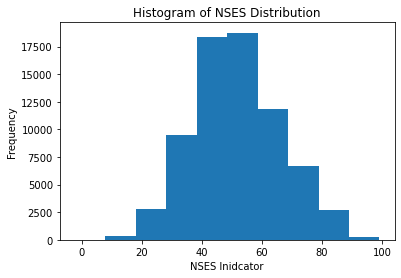

In [11]:
stats.NSES.plot.hist()
plt.title("Histogram of NSES Distribution")
plt.xlabel("NSES Inidcator")

In [12]:
# some numerics Extracted from above
# note that nses indicator is summative, and therefore can fall below 0
stats.NSES.describe()

count    71359.000000
mean        51.667804
std         14.542668
min         -2.257218
25%         41.572354
50%         50.631441
75%         61.253145
max         99.092830
Name: NSES, dtype: float64

A counter-example for unbalanced of individual components to show why we use NSES over other more readable metrics; Different from normal distribution, using directly such economic metrics may potentially lead to innate bias.

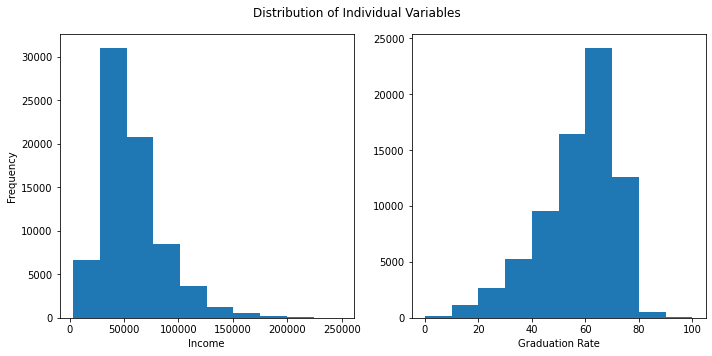

In [138]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.hist(stats['medinc'])
ax1.set_xlabel("Income")
ax1.set_ylabel('Frequency')

plt.hist(stats.HS_grad)
ax2.set_xlabel("Graduation Rate")

fig.suptitle('Distribution of Individual Variables')
plt.tight_layout()

In [13]:
# A glimpse of typical cropland statistics collected
res_cor.columns

Index(['COUNTY', 'STATE_NAME', 'NSES', 'medinc', 'FFH', 'unemp_rate',
       'Poverty', 'HS_grad', 'BA_holder', 'OBJECTID', 'state_name',
       'state_code', 'county_name', 'county_code',
       'CORN_OPERATIONS_WITH_SALES', 'CORN_SALES_IN_DOLLARS',
       'CORN_GRAIN_ACRES_HARVESTED', 'CORN_GRAIN_OPERATIONS_WITH_AREA',
       'CORN_GRAIN_PRODUCTION_IN_BU', 'CORN_GRAIN_IRRIGATED_ACRES_HARV',
       'CORN_GRAIN_IRRIGATED_OPERATIONS', 'CORN_SILAGE_ACRES_HARVESTED',
       'CORN_SILAGE_OPERATIONS_WITH_ARE', 'CORN_SILAGE_PRODUCTION_IN_TONS',
       'CORN_SILAGE_IRRIGATED_ACRES_HAR', 'CORN_SILAGE_IRRIGATED_OPERATION',
       'CORN_TRADITIONAL_OR_INDIAN_ACRE', 'CORN_TRADITIONAL_OR_INDIAN_OPER',
       'CORN_TRADITIONAL_OR_INDIAN_PROD', 'CORN_TRADITIONAL_OR_INDIAN_IRRI',
       'CORN_TRADITIONAL_OR_INDIAN_IR_1', 'Shape__Area', 'Shape__Length',
       'FIPS_Code', 'SHAPE'],
      dtype='object')

# Analysis and Step-wise Results

In [147]:
foi = df.copy()

Map the cropland density, in addition to areas with no records and areas with zero density, count the lowest 5% from the remaining as non-agricultural regions. This forbids trival cross-over among multiple geographic units.

In [148]:
# itemized density
foi['density_cotton'] = foi.COTTON_ACRES_HARVESTED / foi.Shape__Area
foi['density_wheat'] = foi.WHEAT_ACRES_HARVESTED / foi.Shape__Area
foi['density_corn'] = foi.CORN_GRAIN_ACRES_HARVESTED / foi.Shape__Area
# aggregated density
foi['density_overall'] = foi.density_cotton + foi.density_wheat +  foi.density_corn

# categorize agricultural & non-agricultural regions
def ag_category(input_col, data):    
    ag_cutoff = np.percentile(data.loc[foi[input_col]>0][input_col],5)
    res = (data[input_col].isna()) | (data[input_col]<=ag_cutoff)
    return np.invert(res)

foi['agricultural'] = ag_category('density_overall',foi)
foi.agricultural.value_counts()

True     49014
False    22345
Name: agricultural, dtype: int64

#### Confirming Theories On Farm Specialization

As mentioned before, existing studies suggests that farm specialization and centralization mark a difference in the socio-economic status. We would like to check if the same principles hold true for our data based on the existing literatues for different countries and different periods. Similar to NSES index, we could also define the level of agricultural specialization comparatively. That is, a place is specialized in agriculture if it outcompetes the average level.

In [149]:
cut_off = foi.density_overall.mean()

non_ag = foi.loc[~foi.agricultural].groupby(['STATE_NAME','COUNTY']).mean().reset_index().dropna()
ag = foi.loc[
    (foi.agricultural) & (foi.density_overall<cut_off)].groupby(['STATE_NAME','COUNTY']).mean().reset_index().dropna()
ag_specialized = foi.loc[foi.density_overall>=cut_off].groupby(['STATE_NAME','COUNTY']).mean().reset_index().dropna()

Text(0.5, 1.0, 'Socio-Economic Status over Farm Specialization')

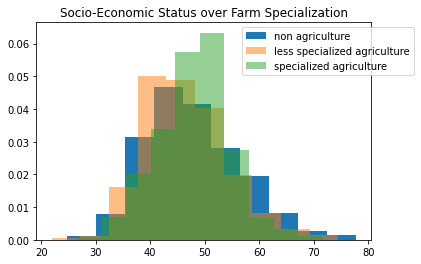

In [150]:
plt.hist(non_ag.NSES,density=True)
plt.hist(ag.NSES,density=True,alpha=0.5)
plt.hist(ag_specialized.NSES,density=True,alpha=0.5)
plt.legend(['non agriculture','less specialized agriculture','specialized agriculture'],bbox_to_anchor=(.6, 1))
plt.title("Socio-Economic Status over Farm Specialization")

In [151]:
# testify a divergence from the entire population by p-value
statistics.ttest_ind(foi.NSES,ag_specialized.NSES).pvalue

6.438976252501173e-20

#### Further Classification

Although direct data for categorizing cropland types are not available, we can approx this categorization from the typology report of USDA, in which it claims that about 8~9% farms constitute to Commercial Farms. Following this definition, we choose regions to be characterized by commercial farmland if their sales were among the top 10% in their kind. We allowed a 2% marginal increase since the report was formed in a earlier period, and it has reconted a consistent growth in the commercial farmland proportion since the begining of the century.

In [152]:
sales_col = ['CORN_SALES_IN_DOLLARS', 'WHEAT_SALES_IN_DOLLARS','COTTON_LINT_AND_SEED_SALES_IN_U']

#get top 10%
pct = []

for i in sales_col:
    pct.append(np.percentile(a=foi[i].dropna(),q=90))

#set variable
foi['commercial'] = (foi.CORN_SALES_IN_DOLLARS.values>pct[0]) | (foi.WHEAT_SALES_IN_DOLLARS.values>pct[1]) | (foi.COTTON_LINT_AND_SEED_SALES_IN_U>pct[2])

Take the state of California as an example, we wish to find out distinctions among agricultrual and non-agricultural(roughly split) regions. We found a pattern where the types of agriculture have contrary effect on local econmics. Specifically, non-commercial agrcultural regions are usually better-off than other areas, while economnic deficiency is witnessed among ares specialized in commercial agriculture.

Text(0.5, 1.0, 'Regional Difference Among Agricultural Types')

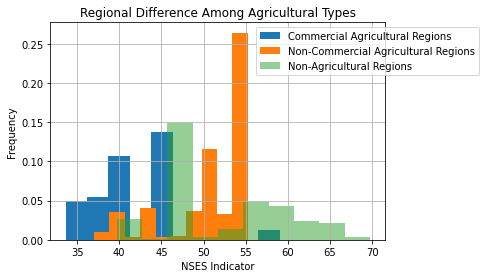

In [153]:
df3 = foi.loc[foi.STATE_NAME=='California'].groupby('COUNTY').mean()[['NSES','density_overall']].reset_index()
df3 = df3.merge(foi.loc[foi.STATE_NAME=='California'][['COUNTY','commercial','agricultural']]#.groupby('COUNTY').max().reset_index()
                ,how='left')

df3.loc[df3.agricultural & df3.commercial].NSES.hist(density=True)
df3.loc[df3.agricultural & (~df3.commercial)].NSES.hist(density=True)
df3.loc[df3.agricultural==False].NSES.hist(density=True,alpha=0.5)

plt.ylabel('Frequency')
plt.xlabel('NSES Indicator')
plt.legend(['Commercial Agricultural Regions','Non-Commercial Agricultural Regions','Non-Agricultural Regions'],
           bbox_to_anchor=(.6, 1))
plt.title('Regional Difference Among Agricultural Types')

In [154]:
statistics.ttest_ind(df3.NSES, df3.loc[df3.density_overall<=0].NSES)

Ttest_indResult(statistic=-12.720824542780655, pvalue=7.551426836714267e-37)

#### Regional Adjacency and Locality

One potential explanation for the above outcome might be that central areas of croplands can be economically inefficient, but as it diffuses to . While this only exists as a plausible reason, it reminds us the necessity to investigte any regional adjancencies among the cropland types. 
In light of this, we would like to take a further look into the extent of locality for agricultural regions. In other words, to what extent can croplands inlfluence its surrounds. The following steps uses an iterative approach to characterize such locality.

In [157]:
# transcribe timely-enabled statistics to single year statistics for better representation
ca_cropland = foi.loc[foi.STATE_NAME=='California'][
    ['COUNTY','SHAPE','agricultural','commercial','NSES']
].groupby('COUNTY').agg({'SHAPE':'first','agricultural':'first','commercial':'first','NSES':'mean'}).reset_index()

ca_cropland.agricultural = ca_cropland.agricultural.astype(int)
ca_cropland.commercial = ca_cropland.commercial.astype(int,copy=False)
# for better viz, adding to categorical indicator such that 
# 0: non-agriculture, 1:non-commercial agriculture and 2: commercial agriculture
ca_cropland['type_n'] = ca_cropland.agricultural + ca_cropland.commercial

Checking the adjancency, we can see that while some commercial agricultural regions connect to less commercialized areas, the same pattern does not hold true for every case. In central California specifically, commercial agricultures are centered by both non-cropland urban aras and some lightly agricultural, but non-commercial areas, rejecting the confounding theorem of diffused croplands.

In [160]:
map1 = gis.map('California')
ca_cropland[['SHAPE','type_n']].spatial.plot(map_widget=map1,col = 'type_n',renderer_type='c',
                                             cmap='YlGn',line_width = 0.1)
map1.legend=True
map1

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [167]:
# Save processed dataset
cropland_fl = ca_cropland.spatial.to_featurelayer('ca_cropland_analysis')

# Conclusion

In the previous steps, we've quantified the magnitude of farm centralization based on production levels. In general, regions that are more specialized in agricultural productions tend to bear better econmic status. We've also detected a contrary observation in California that areas characterized by less commercialized farms are usually better-off than heavily commercialized agricultural areas, which partly expalined how attempts to establish a strict numeric relationships between cropland distributions and economic prosperity could fail, since commercial and non-commercial croplands behave differently. 
In this way, the characteristic of farm commercialization cannot be said to be equal to the regional farm speciallization.<br>

Furthermore, we determied that the agricultural types across neighbouring areas are independent of each other, suggesting that our results are not weakened by the risk of path dependency, in which certain central farming areas can influence the agricultural modes in surroundings.

# Discussions

To assess the outcomes of farmland can still be complicated in a way that its products, whether food or economic plants, serves the country-wide interests, whereas the establishment of the farms ultimately resides on the on local level, and thus have territorial implications. Overall, we've validated the positive impact of ranch centralization on socio-economic welfares. Our results also reveal a negative consequence of farm commercialization, in which commercial farmlands reduces regional economic prosperities, which can be linked to the effect of job choices discussed in the literature. While it is too early to lay down a firm opinion, we would suggest institutions to adopt policies that promotes small but specialized individual farmings, while keeping the regional farmlands density in agricultural territories at least on the current level.


Originally, we plan to make use of a more comprehensive imagery layers of US Cropland Surveys. However, due to various restrictions on ArcGIS functionalities, reprojecting and transferring this raster layer to features work takes an unaffordable amount of running time and credits. Eventually, we decide to trade this information of comprehensive cropland distribution to a distribution among limited amount of crop types, acquired from feature layers that we are about to use any way(to incorporate production and sales data). We hope that by avoiding raster reprojection and raster_to_feature manipulations, the accuracy of the project can be ensured, under the cost of losing a broader perspective from using other spatially-enriched and timely-enabled datasets.

# Further work

Since the current dataset on farmland statistics is based on counties, we can only assess the general trend of cropland establishment and diminishes. Additional detailed survery on farmland changes in a specific area can serve as a desirable case study for conducting futher analysis, especially the changes in the farmland over a longer period of time, together with data of demograohics to evaluate the contribution of farmland on populational growth. Differntly scaled socio-economic metrics can also be useful in providing insights to the internal mechanism among economies and farmlands, should a variable importance analyis be proposed. In the future, we wish to explore more possibilities regarding the Cropland Survey, in which we could explore comparative impact of various crop types and relative productions, with a stronger software support.